# Financial Applications in Qiskit

In this block we:

    * ... we explore the several topics in Qiskit for Finance
    * ... Quantum Amplitude Estimation
    * ... Option Pricing
    * ... Risk Estimation
    * ... towards Monte Carlo dominance

***

... usual declarations

In [1]:
# Import numpy & usual libraries, check the qiskit version etc.
import numpy as np

# Import basic object from the Qiskit
from qiskit import QuantumCircuit
from qiskit import Aer,BasicAer
from qiskit import execute

# We will need these two
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.kernels import QuantumKernel

# Load account from the disk
from qiskit import IBMQ
IBMQ.load_account() 

# We will need this for plots
from qiskit.visualization import plot_histogram,plot_bloch_multivector

In [2]:
# Check the version of the qiskit you use

# Compared to previous class, I have installed the up-to-date version
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

In [3]:
# Ideal simulator
simulator = Aer.get_backend('qasm_simulator')

# Real-like simulator
from qiskit.providers.aer.noise import NoiseModel

# Choose a particuler quantum computer 
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_belem')

# We derive the noise model from the chosen quantum computer
noise_model = NoiseModel.from_backend(backend)

# Further, we assume the specific qauntum computer:
# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# define backend (simulator)
backendSim = QuantumInstance(
    BasicAer.get_backend("qasm_simulator"), shots=1024
)

# define backend (simulator with specific noise)
backendSimWithNoise = QuantumInstance(
    Aer.get_backend("qasm_simulator"), 
    coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model,
                shots=1024
)

ibmqfactory.load_account:WARNING:2022-04-04 17:45:45,296: Credentials are already in use. The existing account in the session will be replaced.


***
# Quantum Amplitude Estimation

The core principle we will exploit is based on the following: Let us consider an operator $A$ which acts as:

$$
A|0>=\sqrt{1-p}|\Psi_0> + \sqrt{p}|\Psi_1>\,,
$$
where $p\in[0,1]$, and we are interested in

$$
p=|<\Psi_1|A|\Psi_1>|^2\,.
$$

The probability $p$ will have various interpretations. There are different algorithms to implement such problem. The original solution is using the Grover operator:

$$
Q=AS_0 A^\dagger S_{\Psi_1}\,,
$$

where $S_X$ is a reflection about the $|X>$ state (it conditionally flips the sign of the amplitudes of good states).

The link: https://arxiv.org/pdf/quant-ph/0005055.pdf

The Grover operator is iteratively applied within the algorithm in the process called amplitude amplification. 

* We will use a prepared function function for amplitude estimation!

Functionally, it is required from us to prepare $A$ and $Q$ explicitly, as well as to specify the "good" state. The operators $A$ and $Q$ are circuits (our mechanical representation of operation). 

Since we need to iterate the $Q$, we need $Q^k$ and thus we need to prepare it as well. For unitsary operators, it can be easy expression -- e.g., for rotation, we may need to apply one gate operator but change the parameter. 


***

***
## Bernoulli Operator

We simulate process which gives us 1 with probability $p$. In terms of Quantum Computing, we can formulate this as:

$$
A|0>=\sqrt{1-p}|0> + \sqrt p |1>\,,
$$
where $p$ is interpreted as probability. 

The operator we can use as $A$ is rotation around $y$, or $R_y(\alpha(p))$ acting on a single qubit. 

$$
A=R_y(\alpha(p))\,,
$$
with
$$
\alpha(p)=2\sin^{-1}(\sqrt p)\,.
$$

In the following, we will review different functions in Qiskit, which we can use to estimate the amplitude of $<1|A|1>$.


***

## Preparation

We need to prepare the operators (circuit). Both operators are derived from the QuantumCircuit class -- approach used by Qiskit.



In [4]:
class BernoulliA(QuantumCircuit):
    """A operator for Bernoulli process.
       The rotation around y-axis by \alpha(p)
    """

    def __init__(self, probability):
        super().__init__(1)  
        
        alpha_p = 2 * np.arcsin(np.sqrt(probability))
        # rotation on the first qubit
        self.ry(alpha_p, 0)


class BernoulliQ(QuantumCircuit):
    """Grover operator Q corresponding to Bernoulli process
       The rotation around y-axis by 2 k \alpha(p) 
    """

    def __init__(self, probability):
        super().__init__(1)  

        self.alpha_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(2 * self.alpha_p, 0)

    def power(self, k):
        # power of the Grover operator -- overloading the power operator
        q_k = QuantumCircuit(1)
        q_k.ry(2 * k * self.alpha_p, 0)
        return q_k

In [5]:
# Define the value of probability
probability = 0.3

A = BernoulliA(probability)
Q = BernoulliQ(probability)

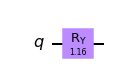

In [6]:
A.draw('mpl')

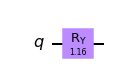

In [7]:
A.draw('mpl')

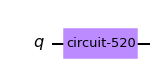

In [8]:
A.power(1).draw('mpl')

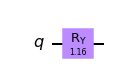

In [9]:
A.power(1).decompose().draw('mpl')

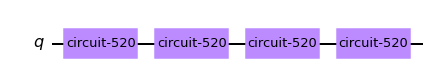

In [10]:
A.power(4).draw('mpl')

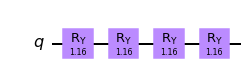

In [11]:
A.power(4).decompose().draw('mpl')

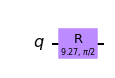

In [12]:
# Out efficient implementation!
# We can work without it, through! 
Q.power(4).decompose().draw('mpl')

***
## Brassard's Estimator

We employ the implementation of the Brassard estimator (see link above). The estimator is implemented for us:

AmplitudeEstimator function

***

In [13]:
# First, we need to wrap up a problem into an object
from qiskit.algorithms import EstimationProblem

# We define problem by specifying A, Q and what is a good state
problem = EstimationProblem(
    state_preparation=A, 
    grover_operator=Q,
    objective_qubits=[0],
)

# Using simulator
backend = BasicAer.get_backend("statevector_simulator")
qi = QuantumInstance(backend)


In [14]:
# Canonical estimation
from qiskit.algorithms import AmplitudeEstimation

# We can set the accuracy by specifying number of qubits
nQubits = 3

ae = AmplitudeEstimation(
    num_eval_qubits=nQubits,  
    quantum_instance=qi,
)



In [15]:
# Solve the problem
aeResult = ae.estimate(problem)

In [16]:
# Accessing the result
aeResult.estimation

0.1464466

***
Result is not accurate, we have small accuracy. Try different number of qubits.
***

In [17]:
nQubits = 4

aeX = AmplitudeEstimation(
    num_eval_qubits=nQubits,  
    quantum_instance=qi,
)
aeX.estimate(problem).estimation

0.3086583

***
... back to 3 qubits.

How the circuit looks?

***

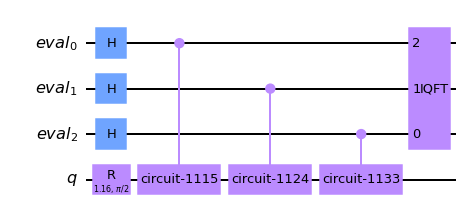

In [18]:
ae.construct_circuit(problem).decompose().draw('mpl')

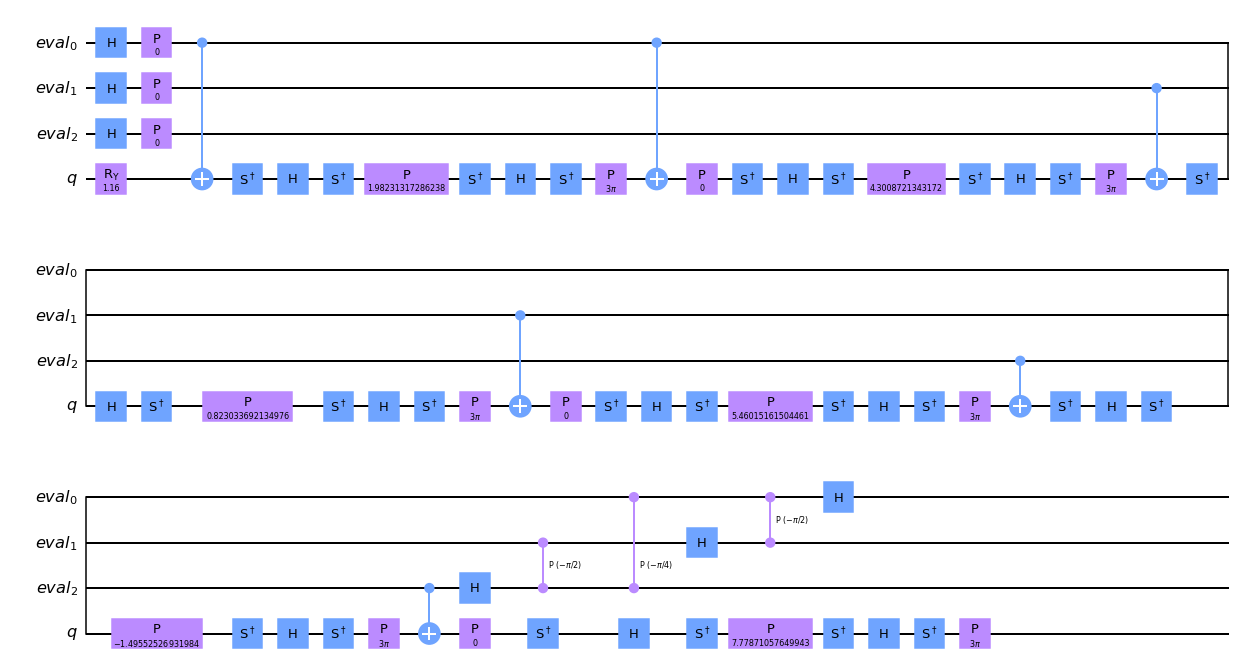

In [19]:
# Decomposing cirucit into elements
from qiskit import transpile
bg = ["h", "ry", "cry", "cx", "ccx", "p", "cp", "x", "s", "sdg", "y", "t", "cz"]
transpile(ae.construct_circuit(problem), basis_gates=bg, optimization_level=2).draw("mpl")

***
Exploring the result object...
***

In [20]:
aeResult.samples

{0.0: 0.051788799999999954,
 1.0: 0.022195199999999988,
 0.5: 0.38841599999999943,
 0.1464466: 0.47255536458331565,
 0.8535534: 0.06504463541668395}

Text(0.5, 0, 'Amplitude p')

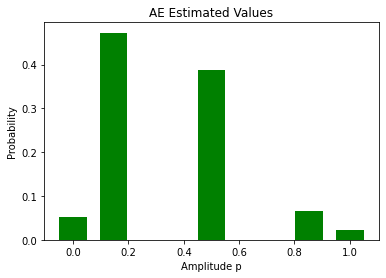

In [21]:
# We can plot a histogram from this object
import matplotlib.pyplot as plt 
plt.bar(list(aeResult.samples.keys()), aeResult.samples.values(), width=0.1, color='g')
plt.title("AE Estimated Values")
plt.ylabel("Probability")
plt.xlabel("Amplitude p")

***
We clealry see that result is not dominated by one amplitude, rather, we see that two values, 0.146 and 0.5 are very likely. This information is used in the implemented MLE estimator -- it helps to find the value of p, which the most likely produces the distribution of amplitudes.

***

In [22]:
# We get very accurate result close to reality: 0.3
aeResult.mle

0.29999999862844184

***
There are three other Qiskit functions, which solve the same problem -- different implementations.
***

***
## Iterative Amplitude Estimations
***

In [23]:
from qiskit.algorithms import IterativeAmplitudeEstimation

iae = IterativeAmplitudeEstimation(
    epsilon_target=0.01, 
    alpha=0.05,  
    quantum_instance=qi,
)
iaeResult = iae.estimate(problem)
iaeResult.estimation

0.29999999999999993

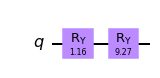

In [24]:
# Try different number of iterations...
iae.construct_circuit(problem, k=4).draw("mpl")


***
## MLE Amplitude Estimations
***

In [25]:
from qiskit.algorithms import MaximumLikelihoodAmplitudeEstimation

mlae = MaximumLikelihoodAmplitudeEstimation(
    evaluation_schedule=3, quantum_instance=qi  
)
mlaeResult = mlae.estimate(problem)
mlaeResult.estimation



0.29999255431916677

***
## Faster Amplitude Estimations
***

In [26]:
from qiskit.algorithms import FasterAmplitudeEstimation

fae = FasterAmplitudeEstimation(
    delta=0.01,
    # Maximum power of the Grover operator
    maxiter=3, 
    quantum_instance=qi,
)
faeResult = fae.estimate(problem)
faeResult.estimation

/Users/jannovotny/opt/anaconda3/envs/qiskit/lib/python3.8/site-packages/qiskit/algorithms/amplitude_estimators/estimation_problem.py:194: UserWarning: Rescaling discards the Grover operator.
  warnings.warn("Rescaling discards the Grover operator.")


0.2999999999999998

***
# Option Pricing -- Application of the Quantum Amplitude Estimation

Let us assume the price of the underlying asset $S_t$, the European call option is a contract, whose pay-off is determined by the price $S_T$ as time $T$ in the future as:

$$
\max(S_T-K,0)\,,
$$
where $K$ is a strike.

At time $t<T$, we can estimate the value of the contract in the future based on the expected distribution of perices. We will use QAE for such a task. 

In the previous section, we have manually implemented circuit, which calculates the Bernoulli distribution. For option pricing, we use the built-in circuit which gives us the log-normal distribution:

$$
|0>_n \to |\Psi>_n = \sum_{i=0}^{2^n-1}\sqrt{p_i}|i>_n\,,
$$
where $p_i$ stands for the discretised pdf and the bucket $i$ is mapped as:

$$
i\to \frac{high-low}{2^n-1}*i+low
$$
with $i \in \{0,\dots,2^n-1\}$ and $high$ and $low$ denoting truncation of the distribution. The circuit is called "LogNormalDistribution".



***

In [27]:
# We have not used qiskit_finance before!
from qiskit_finance.circuit.library import LogNormalDistribution

# accuracy (or number of states)
nQubits = 3

################################################
# parameters 
################################################

# S_t
S = 2.0  
# volatility
vol = 0.4  
# interest rate
r = 0.05  
# days to maturity
T = 10 / 365  

# log-normal distribution
mu = (r - 0.5 * vol ** 2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma ** 2 / 2)
variance = (np.exp(sigma ** 2) - 1) * np.exp(2 * mu + sigma ** 2)
stddev = np.sqrt(variance)

# truncation is +-3 sigma
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# operator(circuit) for QAE
uncertainty_model = LogNormalDistribution(
    nQubits, mu=mu, sigma=sigma ** 2, bounds=(low, high)
)

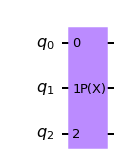

In [28]:
# drawing
uncertainty_model.draw('mpl')

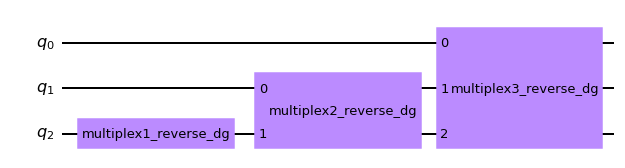

In [29]:
# drawing
uncertainty_model.decompose().draw('mpl')

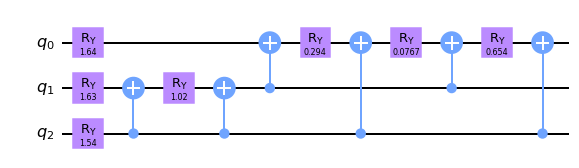

In [30]:
# We can force the decomposition into basis gates
bg = ["h", "ry", "cry", "cx", "ccx", "p", "cp", "x", "s", "sdg", "y", "t", "cz"]
transpile(uncertainty_model, basis_gates=bg, optimization_level=2).draw("mpl")

In [31]:
# We can access the distribution
uncertainty_model.values

array([1.60450989, 1.71829038, 1.83207087, 1.94585136, 2.05963185,
       2.17341234, 2.28719283, 2.40097332])

In [32]:
uncertainty_model.probabilities

array([0.00175469, 0.0296394 , 0.15832399, 0.32520464, 0.300199  ,
       0.14123238, 0.03752108, 0.00612484])

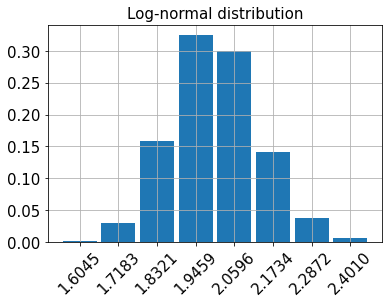

In [33]:
plt.bar(uncertainty_model.values, uncertainty_model.probabilities, width=0.1)
plt.xticks(uncertainty_model.values, size=15, rotation=45)
plt.yticks(size=15)
plt.grid()
plt.title("Log-normal distribution", size=15)
plt.show()

***
The log-normal circuit supports multivariate 
***

In [36]:
mu = [1, 0.9]
sigma = [[0.6, -0.1], [-0.1, 0.6]] 
logNormalMulti = LogNormalDistribution([3, 3], mu, sigma) 

In [37]:
logNormalMulti.values

[(0.0, 0.0),
 (0.0, 0.14285714285714285),
 (0.0, 0.2857142857142857),
 (0.0, 0.42857142857142855),
 (0.0, 0.5714285714285714),
 (0.0, 0.7142857142857142),
 (0.0, 0.8571428571428571),
 (0.0, 1.0),
 (0.14285714285714285, 0.0),
 (0.14285714285714285, 0.14285714285714285),
 (0.14285714285714285, 0.2857142857142857),
 (0.14285714285714285, 0.42857142857142855),
 (0.14285714285714285, 0.5714285714285714),
 (0.14285714285714285, 0.7142857142857142),
 (0.14285714285714285, 0.8571428571428571),
 (0.14285714285714285, 1.0),
 (0.2857142857142857, 0.0),
 (0.2857142857142857, 0.14285714285714285),
 (0.2857142857142857, 0.2857142857142857),
 (0.2857142857142857, 0.42857142857142855),
 (0.2857142857142857, 0.5714285714285714),
 (0.2857142857142857, 0.7142857142857142),
 (0.2857142857142857, 0.8571428571428571),
 (0.2857142857142857, 1.0),
 (0.42857142857142855, 0.0),
 (0.42857142857142855, 0.14285714285714285),
 (0.42857142857142855, 0.2857142857142857),
 (0.42857142857142855, 0.42857142857142855),
 

In [38]:
logNormalMulti.probabilities

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.42822917e-06, 2.49417893e-05, 9.07209230e-05,
       1.91142704e-04, 3.09006970e-04, 4.29434305e-04, 5.42541858e-04,
       0.00000000e+00, 2.75379681e-05, 4.19222903e-04, 1.40718559e-03,
       2.80064797e-03, 4.33188396e-03, 5.80662870e-03, 7.11544872e-03,
       0.00000000e+00, 1.06137203e-04, 1.49110173e-03, 4.77544644e-03,
       9.19278963e-03, 1.38560315e-02, 1.81849948e-02, 2.18894990e-02,
       0.00000000e+00, 2.33005567e-04, 3.09216605e-03, 9.57846050e-03,
       1.80077616e-02, 2.66492975e-02, 3.44549633e-02, 4.09516824e-02,
       0.00000000e+00, 3.88884948e-04, 4.93770781e-03, 1.49049849e-02,
       2.75124998e-02, 4.01400177e-02, 5.12974009e-02, 6.03736045e-02,
       0.00000000e+00, 5.54703874e-04, 6.79335384e-03, 2.00778620e-02,
       3.65096513e-02, 5.26510417e-02, 6.66499872e-02, 7.78151987e-02,
      

/var/folders/jt/q5vq7x852qs55m26mblz_vy00000gn/T/ipykernel_6340/2810404756.py:15: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


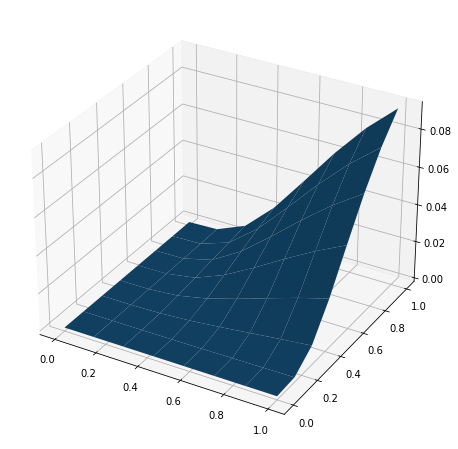

In [43]:
# Plot it
from scipy.interpolate import griddata

x = [v[0] for v in logNormalMulti.values]
y = [v[1] for v in logNormalMulti.values]
z = logNormalMulti.probabilities

resolution = np.array([2 ** n for n in [3,3]]) * 1j

grid_x, grid_y = np.mgrid[min(x) : max(x) : resolution[0], min(y) : max(y) : resolution[1]]

grid_z = griddata((x, y), z, (grid_x, grid_y))

fig = plt.figure(figsize=(10, 8))
ax = fig.gca(projection="3d")
ax.plot_surface(grid_x, grid_y, grid_z)

plt.show()

***
Back to option pricing... 

Next step: The pay-off function of the European call option as a circuit (we have circuit for log-normal distribution of prices, we need to apply another circuit, which will return the pay-off based on simulated prices).

Pay-off:

* returns $0$ if $S(T)<K$
* returns $S(T)-K$ when price exceeds the strike

We need an operator, which performs action when $S>K$ -> flip the ancilla qubit $|0>$ to $|1>$. This controls the linear part of the pay-off.

We construct:

$$
|x>|0>\to |x>(\cos(ax+b)|0>+\sin(ax+b)|1>)
$$
with controlled $y$-rotations.

We will perform measurement on good state $|1>$: 

$$
\sin^2(ax+b) \approx ax+b+\frac{1}{2}-\frac{\pi}{4}\,,
$$
for $ax+b-\pi/4$ close to zero.

This is the linear pay-off. 

We then combine both the log-normal distribution and the pay-off function.
***

In [44]:
# strike price
strike_price = 1.8

In [45]:
from qiskit.circuit.library import LinearAmplitudeFunction

# piecewise linear objective fcuntion
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    nQubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=0.25,
)

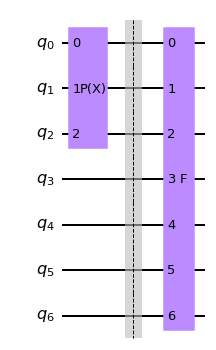

In [46]:
# We combine the circuit together
num_qubits = european_call_objective.num_qubits

european_call = QuantumCircuit(num_qubits)

# Adding the log-normal generator
european_call.append(uncertainty_model, range(nQubits))

# Adding barrier
european_call.barrier()

# Adding piecewise-linear pay-off
european_call.append(european_call_objective, range(num_qubits))

# Drawing the circuit
european_call.draw('mpl')

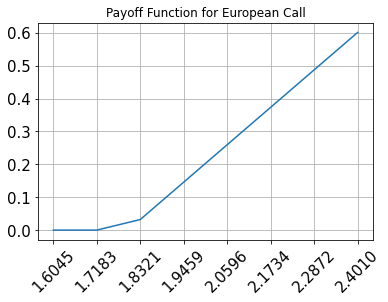

In [47]:
# We can visualise the outcome
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)

plt.plot(x, y)
plt.grid()
plt.title("Payoff Function for European Call")
plt.xticks(x, size=15, rotation=45)
plt.yticks(size=15)
plt.show()

***
We have not run any quantum computations yet, we have so far used the maps in the implemented functions.

We will calculate exact values and compare them with quantum calculations:
***

In [48]:
# Expected value of the option:
np.dot(uncertainty_model.probabilities, y)

0.20514912181322403

In [49]:
# Delta: derivative of the option price wrt price of the underlying
sum(uncertainty_model.probabilities[x >= strike_price])

0.9686059122305676

***
We will use IterativeAmplitudeEstimation as it needs the circuit itself. 

***

In [50]:
problem = EstimationProblem(
    state_preparation=european_call,
    objective_qubits=[3],
    post_processing=european_call_objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(0.01, alpha=0.05, quantum_instance=qi)

In [51]:
aeResult = ae.estimate(problem)

In [52]:
aeResult.estimation_processed

0.20647150902560008

In [53]:
# Expected value of the option:
np.dot(uncertainty_model.probabilities, y)

0.20514912181322403

In [54]:
# Confidence interval
aeResult.confidence_interval_processed

(0.20647150902560008, 0.20647150902560008)

***
The qiskit shortcut:

***

In [55]:
from qiskit_finance.applications.estimation import EuropeanCallPricing

european_call_pricing = EuropeanCallPricing(
    num_state_qubits=nQubits,
    strike_price=strike_price,
    rescaling_factor=0.25,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)

In [56]:
# We define the problem
problem = european_call_pricing.to_estimation_problem()

In [57]:
ae = IterativeAmplitudeEstimation(0.01, alpha=0.05, quantum_instance=qi)
aeResult2 = ae.estimate(problem)

In [58]:
european_call_pricing.interpret(aeResult2)

0.20647150902560008

***
## Multivariate Extension: Basket Option

Let us assume that option is written on a basket of underlying: $S\to (S^{(1)},S^{(2)})$.

The pay-off is now given as:

$$
\max(S_T^{(1)}+S_T^{(2)}-K,0)\,,
$$

where the pay-off is positive, if the sum of values of the two udnerlying assets is at time $T$ above strike value.

What is the difference to one-dimensional case?

* Two-dimensional log-normal distribution (we have tried two-dimensional version)

* Sum of the two log-normal variables before they enter the pay-off function (this is a novel piece!)

Let us review the qiskit implementation of the entire circuit!


***

In [59]:
sigma

[[0.6, -0.1], [-0.1, 0.6]]

In [60]:
# We use the one-dimensional variables as much as possible
# accuracy (or number of states)
nQubits = 3

################################################
# parameters 
################################################

# S_t
S = 2.0  
# volatility
vol = 0.4  
# interest rate
r = 0.05  
# days to maturity
T = 10 / 365  

# log-normal distribution
mu = (r - 0.5 * vol ** 2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma ** 2 / 2)
variance = (np.exp(sigma ** 2) - 1) * np.exp(2 * mu + sigma ** 2)
stddev = np.sqrt(variance)

# truncation is +-3 sigma
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev
dimension = 2
nQubits2D = [nQubits] * dimension
low = low * np.ones(dimension)
high = high * np.ones(dimension)
mu = mu * np.ones(dimension)
cov = (sigma ** 2) * np.eye(dimension)

# log-normal circuit
u = LogNormalDistribution(num_qubits=nQubits2D, mu=mu, sigma=cov, bounds=list(zip(low, high)))

/var/folders/jt/q5vq7x852qs55m26mblz_vy00000gn/T/ipykernel_6340/117437533.py:15: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


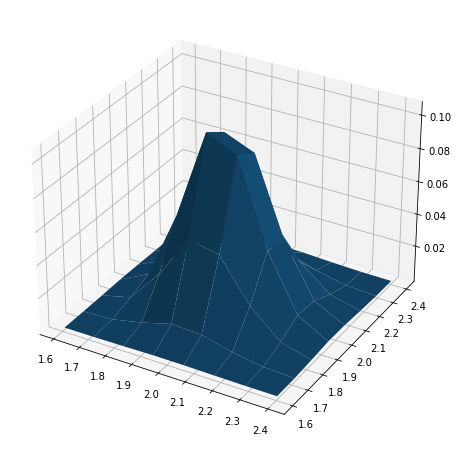

In [61]:
# Plot
from scipy.interpolate import griddata

x = [v[0] for v in u.values]
y = [v[1] for v in u.values]
z = u.probabilities

resolution = np.array([2 ** n for n in nQubits2D]) * 1j

grid_x, grid_y = np.mgrid[min(x) : max(x) : resolution[0], min(y) : max(y) : resolution[1]]

grid_z = griddata((x, y), z, (grid_x, grid_y))

fig = plt.figure(figsize=(10, 8))
ax = fig.gca(projection="3d")
ax.plot_surface(grid_x, grid_y, grid_z)

plt.show()

***
### Weighted Adder

The new circuit: map from register containing two-dimensional log-normal variables to another register with its sum.

***

In [62]:
from qiskit.circuit.library import WeightedAdder

# Adder
weights = []
for n in nQubits2D:
    for i in range(n):
        weights += [2 ** i]

# create aggregation circuit
agg = WeightedAdder(sum(nQubits2D), weights)
n_s = agg.num_sum_qubits

# Additional qubits
n_aux = agg.num_qubits - n_s - agg.num_state_qubits  

In [63]:
weights

[1, 2, 4, 1, 2, 4]

In [64]:
# Number of quibits we need to encode the sum
n_s

4

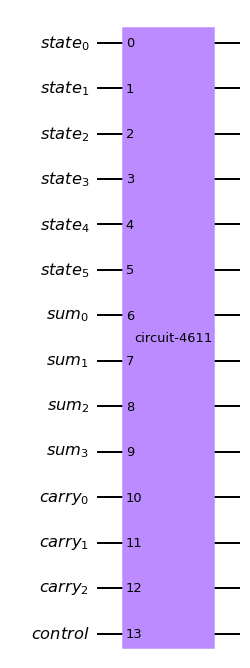

In [65]:
agg.draw('mpl')

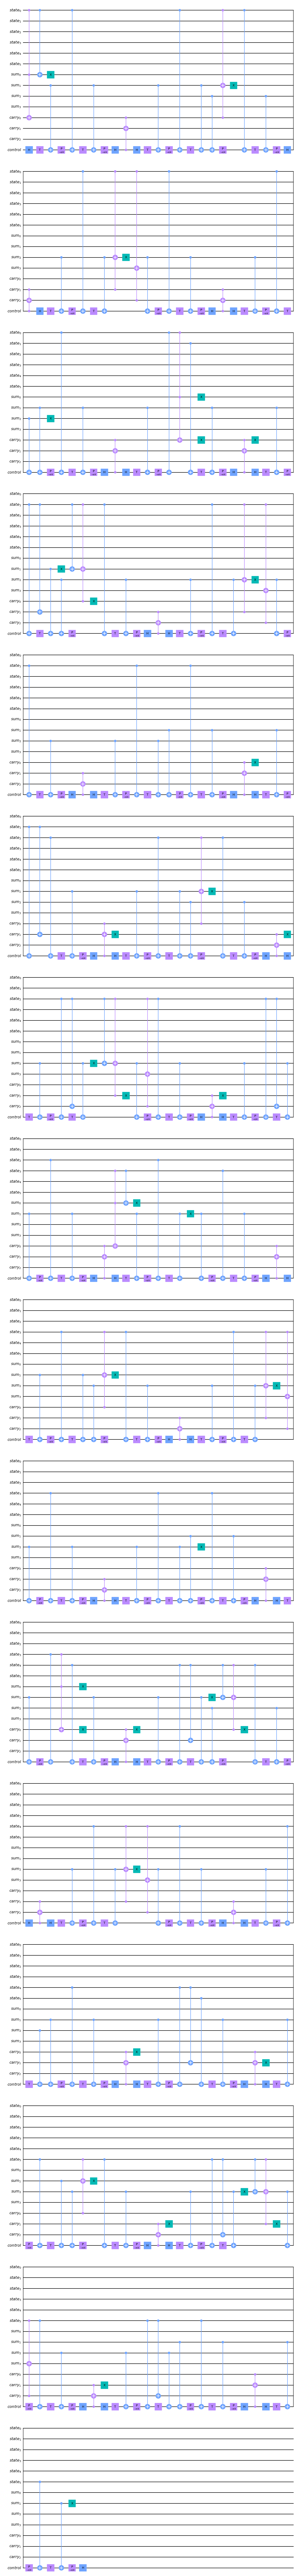

In [66]:
# We can force the decomposition into basis gates
bg = ["h", "ry", "cry", "cx", "ccx", "p", "cp", "x", "s", "sdg", "y", "t", "cz"]
transpile(agg, basis_gates=bg, optimization_level=2).draw("mpl")

***
So far, our the most complicated circuit... for addition!

***

In [67]:
strikePrice = 3.5

# map strike price from [low, high] to {0, ..., 2^n-1}
max_value = 2 ** n_s - 1
low_ = low[0]
high_ = high[0]
mapped_strike_price = (
    (strikePrice - dimension * low_) / (high_ - low_) * (2 ** nQubits - 1)
)


# objective function
breakpoints = [0, mapped_strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = 2 * (2 ** nQubits - 1) - mapped_strike_price

basket_objective = LinearAmplitudeFunction(
    n_s,
    slopes,
    offsets,
    domain=(0, max_value),
    image=(f_min, f_max),
    rescaling_factor=0.25,
    breakpoints=breakpoints,
)

***
Let us build the circuit step-by-step
***

In [68]:
from qiskit import QuantumRegister, AncillaRegister

# The 2-dimensional probability distribution
qr_state = QuantumRegister(u.num_qubits, "state")



In [69]:
# Function values
qr_obj = QuantumRegister(1, "obj") 

In [70]:
# The sum encoding
ar_sum = AncillaRegister(n_s, "sum") 

In [71]:
# Some additional ancilla register
ar = AncillaRegister(max(n_aux, basket_objective.num_ancillas), "work") 

In [72]:
# Index of the quibit we will use in the QAE algorithm
objective_index = u.num_qubits

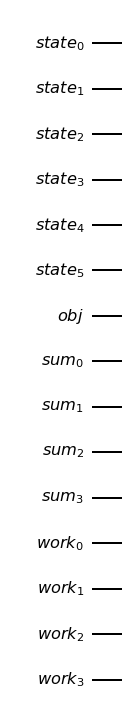

In [73]:
# We create a circuit, which will represent the basket option price
basket_option = QuantumCircuit(qr_state, qr_obj, ar_sum, ar)
basket_option.draw('mpl')

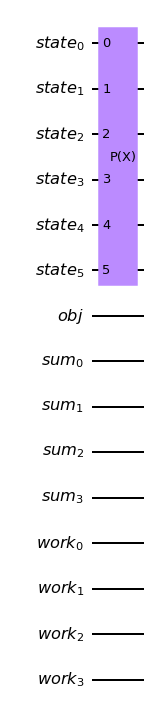

In [74]:
# Adding multivariate distribution
basket_option.append(u, qr_state)
basket_option.draw('mpl')

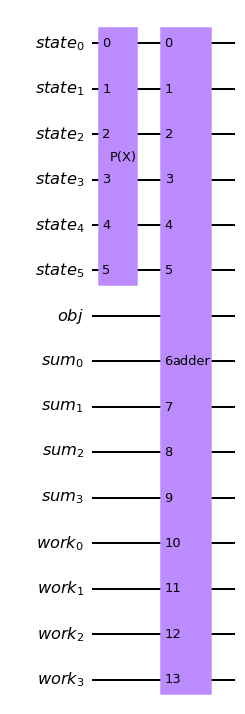

In [75]:
# Aggregation - Adder
basket_option.append(agg, qr_state[:] + ar_sum[:] + ar[:n_aux])
basket_option.draw('mpl')

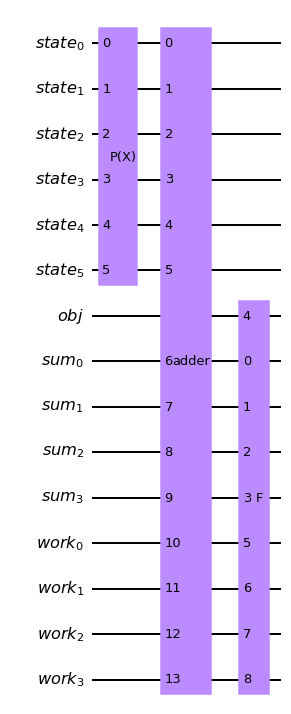

In [76]:
# Pay-off of the option
basket_option.append(basket_objective, ar_sum[:] + qr_obj[:] + ar[: basket_objective.num_ancillas])
basket_option.draw('mpl')


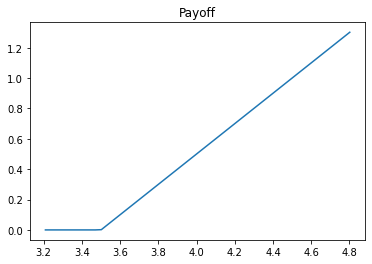

In [88]:
# plot, theoretical behaviour
plt.plot(np.linspace(sum(low), sum(high)),np.maximum(0,np.linspace(sum(low), sum(high))- strikePrice))
plt.title("Payoff")
plt.show()

In [89]:
# Exact value of the option
exact_value = np.dot(
    u.probabilities[np.sum(u.values, axis=1) >= strikePrice],
    np.sum(u.values, axis=1)[np.sum(u.values, axis=1) >= strikePrice] - strikePrice,
)
exact_value

0.5048788245974698

In [90]:
# Circuit properties
num_state_qubits = basket_option.num_qubits - basket_option.num_ancillas
print("state qubits: ", num_state_qubits)
transpiled = transpile(basket_option, basis_gates=["u", "cx"])
print("circuit width:", transpiled.width())
print("circuit depth:", transpiled.depth())

state qubits:  7
circuit width: 15
circuit depth: 997


### State-vector simulation

In [91]:
job = execute(basket_option, backend=Aer.get_backend("statevector_simulator"))

In [92]:
job.result().get_statevector()

Statevector([0.00145897-3.77148573e-18j, 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, ..., 0.        +0.00000000e+00j,
             0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))


In [93]:
value = 0
state = job.result().get_statevector()

In [94]:
if not isinstance(state, np.ndarray):
    state = state.data
for i, a in enumerate(state):
    b = ("{0:0%sb}" % num_state_qubits).format(i)[-num_state_qubits:]
    prob = np.abs(a) ** 2
    if prob > 1e-4 and b[0] == "1":
        value += prob
        
# map the operator value to the range we use
mapped_value = (
    basket_objective.post_processing(value) / (2 ** nQubits - 1) * (high_ - low_)
)


In [95]:
# Exact value of the operator
value

0.4555866592874462

In [96]:
# Mapped value to the range
mapped_value

0.5037262236012301

In [97]:
# EXact value
exact_value

0.5048788245974698

***
### Amplitude Estimation
***

In [98]:
# set the problem
problem = EstimationProblem(
    state_preparation=basket_option,
    objective_qubits=[objective_index],
    post_processing=basket_objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(0.01, alpha=0.05, quantum_instance=qi)

In [99]:
result2D = ae.estimate(problem)

In [100]:
# Estimated value using QAE
result2D.estimation_processed / (2 ** nQubits - 1) * (high_ - low_)



0.5059357813878754

In [101]:
# Confidence einterval
np.array(result2D.confidence_interval_processed)/(2 ** nQubits - 1)*(high_ - low_)

array([0.50593578, 0.50593578])

***
# Some Remarks...

There are number of distributions implemented, for example normal distribution.

***

In [102]:
from qiskit_finance.circuit.library import NormalDistribution

***

There is an increasing number of other financial functions. For exmple, the

FixedIncomePricing

function is calculating the pay-off of the fixed income instrument over a set of horizons, where at every horizon, the enterest rate driving the pay-off is given by a specific random distribution (normal, for example).

... we have idea how the implementation could look like. 


***

***
# Simulating Credit Default Risk

Let us explore another application of the QAE: The portfolio of names, where each name can go default based on the process, which is driven by the same underlying latent process. 

We consider $K$ names, where the probability of default of name $k$ is given as

$$
p_k(z)=F\left(\frac{F^{-1}(p_k^0)-\sqrt{\rho_k}z}{\sqrt{1-\rho_k}} \right)\,, 
$$
where $z$ is a latent random variable from standard normal distribution, $F$ is a cdf of $z$, $p_k^0$ is a default probability of name $k$, and $\rho_k$ is sensitivity to the latent state. 

The default probability is independent across the names, given the realisation of $z$. This model is implemented as Gaussian Conditional independence model. 

The impact of the default of an underlying name is modelled through the variable "loss given default", which is a loss inflicted to the holder in case of a default. For portfolio of $K$ names, the loss is

$$
L=\sum_{k=1}^K \lambda_k X_k\,,
$$
with $\lambda_k$ being loss given default of name $k$. 

### Quantum Representation

We model the default probability of the portfolio of $K$ names as:

$$
|\Psi>=\sum_{i=0}^{2^{n_z}-1}\sqrt{p_z^i}|z_i>\bigotimes_{k=1}^K\left(\sqrt{1-p_k(z_i)}|0>+\sqrt{p_k(z_i)}|1> \right)\,,
$$
where default occurs at state $|1>$ and the sum over $|z_i>$ corresponds to the normally distributed random variable (trimmed, discretised).



***

In [103]:
# parameters

# modelling z -- accuracy, range, and points
n_z = 2
z_max = 2
z_values = np.linspace(-z_max, z_max, 2 ** n_z)

# modelling names
p_zeros = [0.15, 0.25]
rhos = [0.1, 0.05]
lgd = [1, 2]
K = len(p_zeros)

# risk parameter -- VaR level
alpha = 0.05

In [104]:
# We will use Qiskit implementation of the GCI model
from qiskit_finance.circuit.library import GaussianConditionalIndependenceModel as GCI

u = GCI(n_z, z_max, p_zeros, rhos)

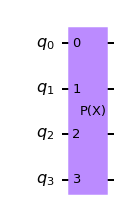

In [105]:
u.draw('mpl')

In [106]:
# state vector simulation
job = execute(u, backend=Aer.get_backend("statevector_simulator"))

In [107]:
# extracting solution from the circuit
p_z = np.zeros(2 ** n_z)
p_default = np.zeros(K)
values = []
probabilities = []
num_qubits = u.num_qubits
state = job.result().get_statevector()

if not isinstance(state, np.ndarray):
    state = state.data

for i, a in enumerate(state):
    # binary representation
    b = ("{0:0%sb}" % num_qubits).format(i)
    prob = np.abs(a) ** 2

    # z
    i_normal = int(b[-n_z:], 2)
    p_z[i_normal] += prob

    # probability of loss and the loss given default
    loss = 0
    for k in range(K):
        if b[K - k - 1] == "1":
            p_default[k] += prob
            # This is the first place we are using how much is losty
            loss += lgd[k]
    values += [loss]
    probabilities += [prob]

In [108]:
values

[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]

In [109]:
# numpy
values = np.array(values)
probabilities = np.array(probabilities)

In [110]:
# expected loss
expected_loss = np.dot(values, probabilities)
expected_loss

0.6408668834510436

In [111]:
# Value at risk at alpha level
losses = np.sort(np.unique(values))

# pdf and cdf
pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])
cdf = np.cumsum(pdf)

# alpha is threshold of the VaR
i_var = np.argmax(cdf >= 1 - alpha)
exact_var = losses[i_var]
exact_var

2

In [112]:
# cdf at VaR level
cdf[exact_var]

0.9590895808630026

In [113]:
# conditional VaR
exact_cvar = np.dot(pdf[(i_var + 1) :], losses[(i_var + 1) :]) / sum(pdf[(i_var + 1) :])
exact_cvar

3.0

Text(0.5, 1.0, 'Distribution of the latent process')

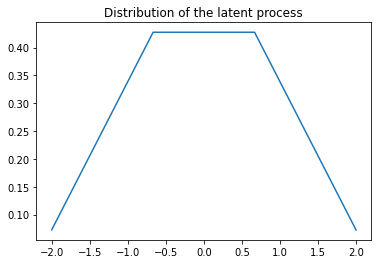

In [114]:
plt.plot(z_values,p_z)
plt.title("Distribution of the latent process")

***
## Expected Loss

There are two steps involved in modelling the expected loss:

1) Weighted sum of individual losses:

$$
|x_1,\dots,x_K>|0>_{n_S}\to |x_1,\dots,x_K>|\lambda_1 x_1+\cdots+\lambda_K x_K>_{n_S}\,,
$$
with $n_S=1+log_2(\lambda_1+\cdots +\lambda_K)$.

2) The weighted sum is mapped on qubit we will measure:

$$
|L>_{n_S}|0>\to |L>_{n_S}\left(\sqrt{1-L/(2^{n_S}-1)}|0>+\sqrt{L/(2^{n_S}-1)}|1> \right)
$$
which is the object of the QAE algorithm and measured. 

***

In [115]:
# Step 1:
from qiskit.circuit.library import WeightedAdder

agg = WeightedAdder(n_z + K, [0] * n_z + lgd)


In [116]:
# Step 2:

breakpoints = [0]
slopes = [1]
offsets = [0]
f_min = 0
f_max = sum(lgd)

objective = LinearAmplitudeFunction(
    agg.num_sum_qubits,
    slope=slopes,
    offset=offsets,
    domain=(0, 2 ** agg.num_sum_qubits - 1),
    image=(f_min, f_max),
    rescaling_factor=0.25,
    breakpoints=breakpoints,
)


***
### Circuit
***

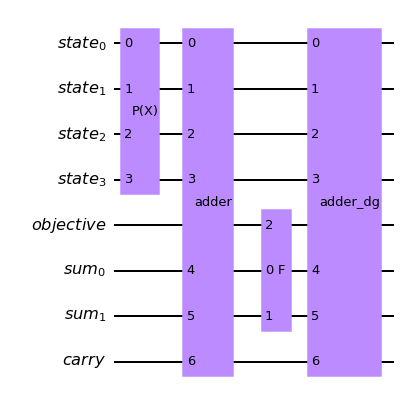

In [117]:
qr_state = QuantumRegister(u.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")

# The objective qubit for QAE -- state 1 is loss (event)
qr_obj = QuantumRegister(1, "objective")

# define the circuit
state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, name="A")

# load the random variable
state_preparation.append(u.to_gate(), qr_state)

# aggregate
state_preparation.append(agg.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:])

# linear objective function
state_preparation.append(objective.to_gate(), qr_sum[:] + qr_obj[:])

# uncompute aggregation
state_preparation.append(agg.to_gate().inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])

# draw the circuit
state_preparation.draw('mpl')

***
We will review the solution when evaluating the state vector and running the simulation with QAE. 

***

In [118]:
# state vector simulation
job = execute(state_preparation, backend=Aer.get_backend("statevector_simulator"))

In [123]:
# evaluate resulting statevector
value = 0
state = job.result().get_statevector()
if not isinstance(state, np.ndarray):
    state = state.data

In [124]:
for i, a in enumerate(state):
    b = ("{0:0%sb}" % (len(qr_state) + 1)).format(i)[-(len(qr_state) + 1) :]
    prob = np.abs(a) ** 2
    if prob > 1e-6 and b[0] == "1":
        value += prob

In [125]:
# Operator value
value

0.39056038135827364

In [126]:
# Mapped value -- expected loss obtained by state vector simulation
objective.post_processing(value)

0.6639428987077111

In [127]:
# Using the QAE -- IterativeAmplitudeEstimation

problem = EstimationProblem(
    state_preparation=state_preparation,
    objective_qubits=[len(qr_state)],
    post_processing=objective.post_processing,
)
# construct amplitude estimation with 0.01 precision and 0.05 confidence level
ae = IterativeAmplitudeEstimation(0.01, alpha=0.05, quantum_instance=qi)


In [129]:
result = ae.estimate(problem)


In [130]:
# Expected loss using QAE
result.estimation_processed

0.6639428987076992

In [132]:
# With confidence interval
np.array(result.confidence_interval_processed)


array([0.6639429, 0.6639429])

***
## CDF

Another potential speed up using Quantum Computers is for estimating cdf. Classically, this requires Monte Carlo Simulations (or full solution).

The quantum estimation of the cdf is first using the calculation of the total loss and then integer comparator, which for given $x$ acts as (having $2^{n_S}$ counting qubits for accuracy of the cdf):

$$
\sum_{i=0}^{x}|L>_{n_S}|1>+\sum_{i=x+1}^{2^{n_S}-1}|L>_{n_S}|0>\,,
$$

which can be prepared at once without need to run number of simulations!

Let us write a Qiskit solution for this: 

***

In [134]:
# Value to be compared
xTarget = 2

# Comparator circuit
from qiskit.circuit.library import IntegerComparator
comparator = IntegerComparator(agg.num_sum_qubits, xTarget + 1, geq=False)
comparator.draw()

┌──────┐
state_0: ┤0     ├
         │      │
state_1: ┤1     ├
         │  cmp │
compare: ┤2     ├
         │      │
     a6: ┤3     ├
         └──────┘

In [138]:
# We prepare a circuit, for given xTarget
xTarget=2

# register
qr_state = QuantumRegister(u.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
qr_obj = QuantumRegister(1, "objective")
qr_compare = QuantumRegister(1, "compare")

# circuit
state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, name="A")

# load the random variable
state_preparation.append(u, qr_state)

# aggregate
state_preparation.append(agg, qr_state[:] + qr_sum[:] + qr_carry[:])

# integer comparator
comparator = IntegerComparator(agg.num_sum_qubits, xTarget + 1, geq=False)
state_preparation.append(comparator, qr_sum[:] + qr_obj[:] + qr_carry[:])

# uncompute aggregation
state_preparation.append(agg.inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])



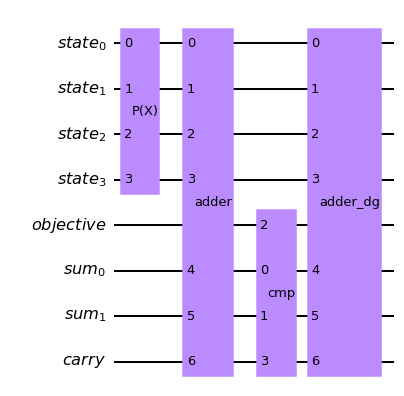

In [140]:
state_preparation.draw('mpl')

In [141]:
# state vector simulation

job = execute(state_preparation, backend=Aer.get_backend("statevector_simulator"))

In [142]:
var_prob = 0
state = job.result().get_statevector()
if not isinstance(state, np.ndarray):
    state = state.data
for i, a in enumerate(state):
    b = ("{0:0%sb}" % (len(qr_state) + 1)).format(i)[-(len(qr_state) + 1) :]
    prob = np.abs(a) ** 2
    if prob > 1e-6 and b[0] == "1":
        var_prob += prob

In [143]:
# cdf(2) of the losses
var_prob

0.9590895808630026

In [144]:
#v Recal from above:
cdf[exact_var]

0.9590895808630026

In [145]:
# USing QAE

problem = EstimationProblem(state_preparation=state_preparation, objective_qubits=[len(qr_state)])
# construct amplitude estimation
ae_cdf = IterativeAmplitudeEstimation(0.01, alpha=0.05, quantum_instance=qi)

result_cdf = ae_cdf.estimate(problem)



In [146]:
# QAE estimated value -- without any Monte Carlo!
result_cdf.estimation

0.9590895808629982

In [148]:
# Confidence level
result_cdf.confidence_interval

(0.9590895808629982, 0.9590895808629982)

In [149]:
# What objective qubit we have used?
[len(qr_state)]

[4]

***
Integer comparator:

Operator compares basis states $|i>_n$ against a classically given integer $L$ of fixed value and flips a target qubit if $i\geq L$ (or the other way around, geq=False), 

$$
|i>_n|0>\to |i>_n|i\geq L>\,.
$$

***

In [150]:
# Disecting results -- sometimes this is useful
var_prob = 0
state = job.result().get_statevector()

In [151]:
if not isinstance(state, np.ndarray):
    state = state.data

In [155]:
for i, a in enumerate(state):
    b = ("{0:0%sb}" % (len(qr_state) + 1)).format(i)[-(len(qr_state) + 1) :]
    print(b)
    print(a)
    prob = np.abs(a) ** 2
    if prob > 1e-6 and b[0] == "1":
        var_prob += prob

00000
(-0+0j)
00001
(-0+0j)
00010
(-0+0j)
00011
(-0+0j)
00100
(-0+0j)
00101
(-0+0j)
00110
(-0+0j)
00111
(-0+0j)
01000
(-0+0j)
01001
(-0+0j)
01010
(-0+0j)
01011
(-0+0j)
01100
(0.09494568887196475+0j)
01101
(0.15440147018194775+0j)
01110
(0.08844203687199403+0j)
01111
(0.015294686044873534+0j)
10000
(0.17277174653494304+0j)
10001
(0.49469055996072037+0j)
10010
(0.5579520461380065+0j)
10011
(0.24909627520936406+0j)
10100
(0.11626568127383484+0j)
10101
(0.23927570751459776+0j)
10110
(0.177921670114358+0j)
10111
(0.04195603514972005+0j)
11000
(0.1410900646918955+0j)
11001
(0.31921731853371005+0j)
11010
(0.277349102026892+0j)
11011
(0.0908057520373218+0j)
11100
(-0+0j)
11101
(-0+0j)
11110
(-0+0j)
11111
(-0+0j)
00000
(-0+0j)
00001
(-0+0j)
00010
(-0+0j)
00011
(-0+0j)
00100
(-0+0j)
00101
(-0+0j)
00110
(-0+0j)
00111
(-0+0j)
01000
(-0+0j)
01001
(-0+0j)
01010
(-0+0j)
01011
(-0+0j)
01100
(-0+0j)
01101
(-0+0j)
01110
(-0+0j)
01111
(-0+0j)
10000
(-0+0j)
10001
(-0+0j)
10010
(-0+0j)
10011
(-0+0j)
10100


***
# Optimisation

The last application from the Qiskit library ready to be used is the portfolio optimisation:

In general, many NP-complete and NP-hard problems can be translated into Quantum Problem -- finding the minimum or ground energy of a quantum system of composed of spin particles with some interaction. The model used is an Ising glass model. 


https://www.frontiersin.org/articles/10.3389/fphy.2014.00005/full

The paper is overview of translations of the common optimisation problems into quantum language. Then, having the Hamiltonian formulation allows us to solve the set of problems using the same quantum toolbox. 

Qiskit has two options for us available:

* Variational Quantum Eigensolver (minimising state of the Hamiltonian using variational maethod)
s
* Quantum Approximate Optimization Algorithm (graph based approach)


## Qiskit Illustration

The Qiskit does have a specific problem implemented -- the portfolio optimisation using mean-variance optimisation. The problem is a quadratic optimisation problem with linear constrain. Our objective is to choose $B$ assets given known covariance structure and expected returns. In particular:

$$
\min_{x\in \{0,1\}^n} q x^T \Sigma x -\mu^T x
$$
s.t.
$$
1^T x= B\,.
$$

Our goal is to make binary decision up to a budget $B$. The problem is translated into finding the ground state using some Quantum routine. 


***

***
### Setting the problem

***

In [162]:
num_assets = 4

from qiskit_finance.data_providers import RandomDataProvider
import datetime

stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2022, 3, 1),
    end=datetime.datetime(2022, 3, 30),
    seed=44,
)

data.run()

mu = data.get_period_return_mean_vector()

sigma = data.get_period_return_covariance_matrix()

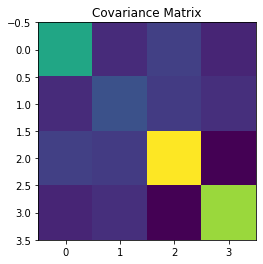

In [163]:
plt.imshow(sigma, interpolation="nearest")
plt.title('Covariance Matrix')
plt.show()

# We have chosen seed to have nice picture

***
### Portfolio Optimisation problem 


***

In [165]:
from qiskit_finance.applications.optimization import PortfolioOptimization

# risk factor
q = 0.5  

# budget
budget = 2  # set budget

# penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)

In [166]:
# We can traslate the problem into quadratic optimisation problem
qp = portfolio.to_quadratic_program()
qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.003020016738 x_0 - 0.001516352603 x_1 - 0.003603378816 x_2
      - 0.000300123705 x_3 + [ 0.000448518254 x_0^2 + 0.000027210559 x_0*x_1
      + 0.000151177294 x_0*x_2 - 0.000009286748 x_0*x_3 + 0.000129430760 x_1^2
      + 0.000120324654 x_1*x_2 + 0.000049489326 x_1*x_3 + 0.000827210719 x_2^2
      - 0.000204570519 x_2*x_3 + 0.000686481440 x_3^2 ]/2
Subject To
 c0: x_0 + x_1 + x_2 + x_3 = 2

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1

Binaries
 x_0 x_1 x_2 x_3
End

***
### Some utilities

We have two function provided by qiskit to visualise outcome:

***

In [168]:
from qiskit_optimization.converters import QuadraticProgramToQubo

def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))

***
## Classical Numpy Solution

***

In [169]:
from qiskit.algorithms import NumPyMinimumEigensolver 
from qiskit_optimization.algorithms import MinimumEigenOptimizer

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [1. 0. 1. 0.], value -0.0059

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 1 0]	-0.0059		1.0000
 [1 1 1 1]	4.0317		0.0000
 [0 1 1 1]	1.0052		0.0000
 [1 0 1 1]	1.0038		0.0000
 [0 0 1 1]	-0.0032		0.0000
 [1 1 0 1]	1.0056		0.0000
 [0 1 0 1]	-0.0014		0.0000
 [1 0 0 1]	-0.0028		0.0000
 [0 0 0 1]	1.0098		0.0000
 [1 1 1 0]	1.0025		0.0000
 [0 1 1 0]	-0.0046		0.0000
 [0 0 1 0]	1.0066		0.0000
 [1 1 0 0]	-0.0042		0.0000
 [0 1 0 0]	1.0083		0.0000
 [1 0 0 0]	1.0070		0.0000
 [0 0 0 0]	4.0391		0.0000


***
## Variational Quantum Eigensolver


***

In [173]:
from qiskit.utils import algorithm_globals
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms import VQE

algorithm_globals.random_seed = 42
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)

ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")

quantum_instance = QuantumInstance(backend=backend, seed_simulator=42, seed_transpiler=42)

vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)

vqe = MinimumEigenOptimizer(vqe_mes)

result = vqe.solve(qp)

print_result(result)

Optimal: selection [1. 0. 1. 0.], value -0.0059

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 1]	-0.0014		0.7463
 [1 1 0 0]	-0.0042		0.2310
 [0 1 1 0]	-0.0046		0.0152
 [1 0 0 1]	-0.0028		0.0057
 [0 0 1 1]	-0.0032		0.0010
 [1 0 1 0]	-0.0059		0.0006
 [0 0 1 0]	1.0066		0.0001
 [1 1 1 0]	1.0025		0.0000
 [0 0 0 1]	1.0098		0.0000
 [1 0 0 0]	1.0070		0.0000
 [1 0 1 1]	1.0038		0.0000
 [0 1 1 1]	1.0052		0.0000
 [1 1 1 1]	4.0317		0.0000
 [0 0 0 0]	4.0391		0.0000
 [1 1 0 1]	1.0056		0.0000
 [0 1 0 0]	1.0083		0.0000


***
## Quantum Approximate Optimization Algorithm

***

In [174]:
from qiskit.algorithms import QAOA

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=42, seed_transpiler=42)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [1. 0. 1. 0.], value -0.0059

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 1 0]	-0.0059		0.1673
 [0 1 1 0]	-0.0046		0.1669
 [1 1 0 0]	-0.0042		0.1668
 [0 0 1 1]	-0.0032		0.1665
 [1 0 0 1]	-0.0028		0.1664
 [0 1 0 1]	-0.0014		0.1661
 [1 1 1 1]	4.0317		0.0000
 [0 0 0 0]	4.0391		0.0000
 [1 1 1 0]	1.0025		0.0000
 [1 0 1 1]	1.0038		0.0000
 [0 0 0 1]	1.0098		0.0000
 [0 1 1 1]	1.0052		0.0000
 [0 1 0 0]	1.0083		0.0000
 [1 1 0 1]	1.0056		0.0000
 [1 0 0 0]	1.0070		0.0000
 [0 0 1 0]	1.0066		0.0000
